# Part 1: CNN + RNN/LSTM Implementation – Video Classification Task

**-Preprocess the Data:**

In [ ]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split


In [1]:
# Step 1: Set up Kaggle and Download the Datasets
from google.colab import files
import zipfile
import os

# Upload Kaggle API key
files.upload()

# Move the Kaggle API key to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download UCF50 Dataset
!kaggle datasets download -d pypiahmad/realistic-action-recognition-ucf50
with zipfile.ZipFile("realistic-action-recognition-ucf50.zip", 'r') as zip_ref:
    zip_ref.extractall("UCF50")

# Download CelebA Dataset
!kaggle datasets download -d jessicali9530/celeba-dataset
with zipfile.ZipFile("celeba-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("CelebA")



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/pypiahmad/realistic-action-recognition-ucf50
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.04G/3.04G [02:37<00:00, 18.7MB/s]
100% 3.04G/3.04G [02:37<00:00, 20.7MB/s]
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:03<00:00, 22.3MB/s]
100% 1.33G/1.33G [01:03<00:00, 22.4MB/s]


In [2]:
import cv2
import numpy as np
import os

def extract_and_process_frames(video_path, num_frames=15, target_size=(64, 64)):
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    extracted_frames = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()

        if ret:
            resized_frame = cv2.resize(frame, target_size)
            normalized_frame = resized_frame / 255.0
            extracted_frames.append(normalized_frame)
        else:
            print(f"Failed to read frame at index {idx} from {video_path}")

    cap.release()

    return np.array(extracted_frames)

def process_videos_in_directory(directory_path):
    all_frames = {}

    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith(('.mp4', '.avi', '.mkv')):  # Add more formats if needed
                video_path = os.path.join(root, file)
                frames = extract_and_process_frames(video_path)
                all_frames[video_path] = frames

                print(f"Processed {video_path}: {frames.shape}")

    return all_frames

# Example usage
main_directory = '/content/UCF50'
all_video_frames = process_videos_in_directory(main_directory)

Streaming output truncated to the last 5000 lines.
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g19_c02.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g15_c02.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g11_c05.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g25_c04.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g09_c04.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g02_c01.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g02_c03.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g25_c01.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g24_c03.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g12_c03.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_SalsaSpin_g03_c02.avi: (15, 64, 64, 3)
Processed /content/UCF50/UCF50/SalsaSpin/v_Sals

**- Implement a CNN + RNN Hybrid Model:**

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the CNN + RNN Hybrid Model
def create_cnn_rnn_model(input_shape, num_classes):
    model = Sequential()

    # CNN Part for Feature Extraction
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Apply activation, padding, and kernel_regularizer directly to Conv2D
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))))

    # Flatten the output to prepare it for the RNN
    model.add(TimeDistributed(Flatten()))

    # RNN/LSTM Part for Temporal Modeling
    model.add(LSTM(64, return_sequences=False))  # Change to True if stacking more LSTMs

    # Fully Connected Layer for Classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7))  # Dropout layer to reduce overfitting
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Example configuration
classes = ['class1', 'class2', 'class3']  # Replace with your actual class names or add more classes
input_shape = (15, 64, 64, 3)  # (time_steps, height, width, channels)
num_classes = len(classes)  # Number of classes in the dataset

# Create the model
model = create_cnn_rnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 15, 64, 64, 32)      │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 32, 32, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 15, 32, 32, 64)      │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 15, 16, 16, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 15, 16, 16, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 15, 8, 8, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 15, 8, 8, 32)        │          36,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 15, 2048)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │         540,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 679,779 (2.59 MB)

 Trainable params: 679,779 (2.59 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the path to your data directory and parameters
data_directory = '/content/UCF50/UCF50'  # Replace with the actual path to UCF50
frame_size = (64, 64)  # Resize each frame to this size
sequence_length = 15  # Number of frames per video sequence
classes = sorted(os.listdir(data_directory))  # Automatically fetch class names from directory structure

# Initialize lists to store the data
features = []
labels = []

# Load videos from each class folder
for label, class_name in enumerate(classes):
    class_path = os.path.join(data_directory, class_name)

    # Check if the class_path exists and is a directory
    if not os.path.isdir(class_path):
        print(f"Skipping {class_path}, as it's not a directory.")
        continue

    for video_name in os.listdir(class_path):
        video_path = os.path.join(class_path, video_name)
        print(f"Processing video: {video_path}")  # Debug: print video path

        cap = cv2.VideoCapture(video_path)

        # Check if the video was opened successfully
        if not cap.isOpened():
            print(f"Failed to open video: {video_path}")
            continue

        # Read frames from the video
        frames = []
        while len(frames) < sequence_length:
            ret, frame = cap.read()
            if not ret:
                print(f"End of video or read error in {video_path}")
                break  # Stop if no more frames
            frame = cv2.resize(frame, frame_size)  # Resize frame
            frames.append(frame)

        cap.release()

        # Ensure we have enough frames; skip videos that are too short
        if len(frames) == sequence_length:
            features.append(np.array(frames))
            labels.append(label)
        else:
            print(f"Skipping {video_path} due to insufficient frames ({len(frames)}/{sequence_length})")

# Check if data was loaded successfully
if not features:
    print("No data loaded. Check if video files are accessible and contain enough frames.")
else:
    # Convert to numpy arrays and normalize
    features = np.array(features) / 255.0  # Normalize pixel values
    labels = to_categorical(labels, num_classes=len(classes))  # One-hot encode labels

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Check the shapes of the data
    print("Training data shape:", X_train.shape)
    print("Validation data shape:", X_val.shape)
    print("Training labels shape:", y_train.shape)
    print("Validation labels shape:", y_val.shape)


Streaming output truncated to the last 5000 lines.
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g06_c01.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g22_c02.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g24_c09.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g07_c01.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g11_c02.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g18_c01.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g23_c03.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g25_c01.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g12_c02.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g06_c03.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g02_c01.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g17_c04.avi
Processing video: /content/UCF50/UCF50/HorseRace/v_HorseRace_g19_c02.avi


In [5]:
# Define the CNN + RNN Hybrid Model
def create_cnn_rnn_model(input_shape, num_classes):
    model = Sequential()

    # CNN Part for Feature Extraction
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Apply activation, padding, and kernel_regularizer directly to Conv2D
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))))

    # Flatten the output to prepare it for the RNN
    model.add(TimeDistributed(Flatten()))

    # RNN/LSTM Part for Temporal Modeling
    model.add(LSTM(64, return_sequences=False))  # Change to True if stacking more LSTMs

    # Fully Connected Layer for Classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.7))  # Dropout layer to reduce overfitting

    # Update this layer to output 'num_classes' units
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Set num_classes to 50 based on your dataset
num_classes = 50  # Ensure this matches the number of classes in your dataset
input_shape = (15, 64, 64, 3)  # Example input shape for your model

# Create the model
model = create_cnn_rnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,  # Experiment with different batch sizes if needed
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)


Epoch 1/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - accuracy: 0.0182 - loss: 4.0541 - val_accuracy: 0.0277 - val_loss: 3.9085
Epoch 2/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.0240 - loss: 3.9083 - val_accuracy: 0.0277 - val_loss: 3.9075
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.0303 - loss: 3.9061 - val_accuracy: 0.0277 - val_loss: 3.9048
Epoch 4/50
115/334 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.0255 - loss: 3.9023

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-7a5cd8297bc0>", line 8, in <cell line: 8>
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function

TypeError: object of type 'NoneType' has no len()

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 53s 427ms/step - accuracy: 0.0333 - loss: 3.9071 - val_accuracy: 0.1212 - val_loss: 3.6910 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.1082 - loss: 3.7099 - val_accuracy: 0.1675 - val_loss: 3.5114 - learning_rate: 1.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.1390 - loss: 3.5310 - val_accuracy: 0.2147 - val_loss: 3.3448 - learning_rate: 1.0000e-04
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.1883 - loss: 3.3416 - val_accuracy: 0.2483 - val_loss: 3.1841 - learning_rate: 1.0000e-04
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.2276 - loss: 3.1786 - val_accuracy: 0.3014 - val_loss: 3.0343 - learning_rate: 1.0000e-04
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.2788 - loss: 3.0378 - val_accuracy: 0.3246 - val_loss: 2.8943 - learning_rate: 1.0000e-04
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - acc

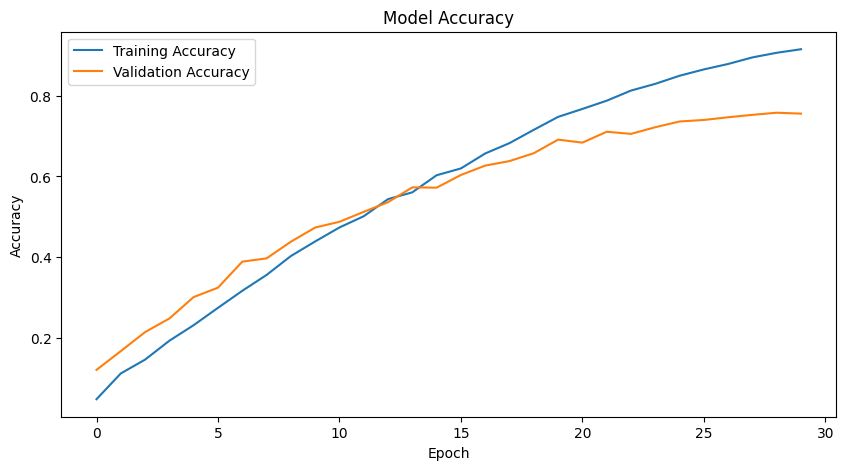

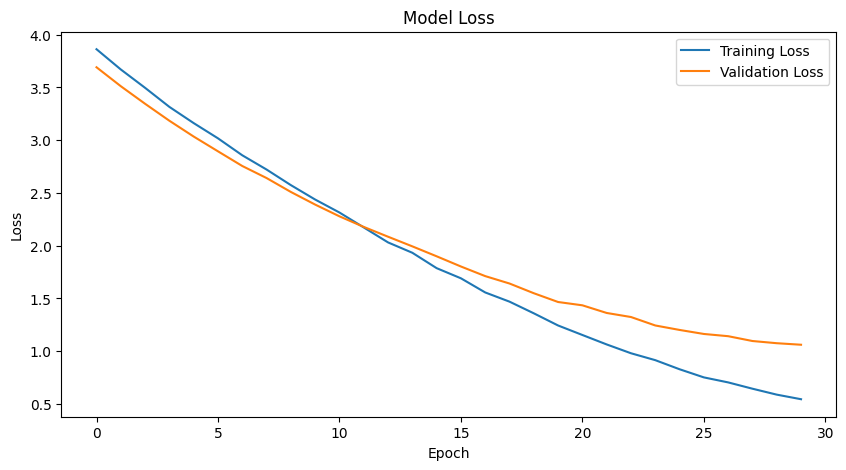

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Enable mixed precision for faster computation on GPUs (no 'experimental' namespace needed)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define the optimized and efficient CNN + RNN model
def create_efficient_cnn_rnn_model(input_shape, num_classes):
    model = Sequential()

    # Efficient CNN Part for Feature Extraction
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten the output to prepare for the RNN
    model.add(TimeDistributed(Flatten()))

    # LSTM Part for Temporal Modeling
    model.add(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Fully Connected Layers for Classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Dropout to prevent overfitting
    model.add(Dense(num_classes, activation='softmax', dtype='float32'))  # Output in float32 for final layer

    return model

# Model parameters
input_shape = (15, 64, 64, 3)  # Shape of the input: (time_steps, height, width, channels)
num_classes = 50  # Number of classes in your dataset

# Initialize the model
model = create_efficient_cnn_rnn_model(input_shape, num_classes)

# Compile with AdamW optimizer and learning rate decay
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_efficient.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,  # Larger batch size to utilize GPU more efficiently
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**-Train and Evaluate the Model:**

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 469ms/step - accuracy: 0.0317 - loss: 3.9675 - val_accuracy: 0.1032 - val_loss: 3.6408 - learning_rate: 1.0000e-04
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.0900 - loss: 3.6513 - val_accuracy: 0.1645 - val_loss: 3.4481 - learning_rate: 1.0000e-04
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.1350 - loss: 3.4554 - val_accuracy: 0.2259 - val_loss: 3.2521 - learning_rate: 1.0000e-04
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.1782 - loss: 3.2782 - val_accuracy: 0.2723 - val_loss: 3.0949 - learning_rate: 1.0000e-04
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 186ms/step - accuracy: 0.2377 - loss: 3.1023 - val_accuracy: 0.3194 - val_loss: 2.9425 - learning_rate: 1.0000e-04
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.2687 - loss: 2.9563 - val_accuracy: 0.3500 - val_loss: 2.7968 - learning_rate: 1.0000e-04
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - acc

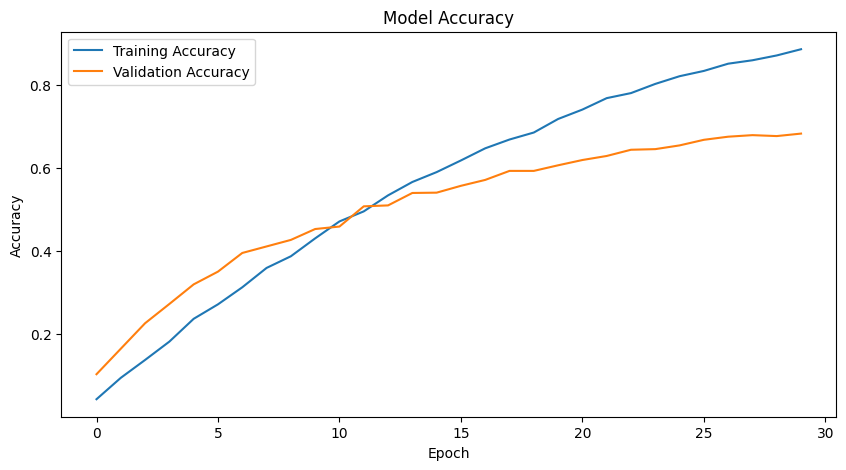

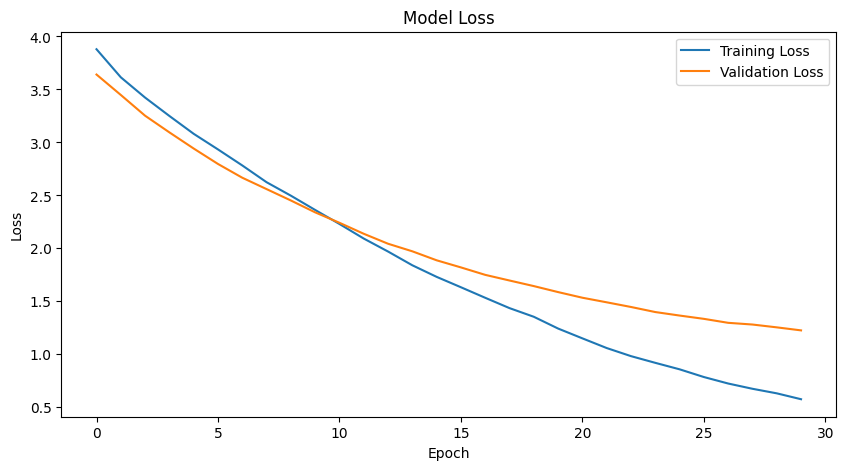

In [7]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Enable mixed precision for faster computation on GPUs
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Define the optimized and efficient CNN + RNN model
def create_efficient_cnn_rnn_model(input_shape, num_classes):
    model = Sequential()

    # Efficient CNN Part for Feature Extraction
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten the output to prepare for the RNN
    model.add(TimeDistributed(Flatten()))

    # SimpleRNN Part for Temporal Modeling
    model.add(SimpleRNN(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))

    # Fully Connected Layers for Classification
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))  # Dropout to prevent overfitting
    model.add(Dense(num_classes, activation='softmax', dtype='float32'))  # Output in float32 for final layer

    return model

# Model parameters
input_shape = (15, 64, 64, 3)  # Shape of the input: (time_steps, height, width, channels)
num_classes = 50  # Number of classes in your dataset

# Initialize the model
model = create_efficient_cnn_rnn_model(input_shape, num_classes)

# Compile with AdamW optimizer and learning rate decay
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model_efficient.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,  # Larger batch size to utilize GPU more efficiently
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


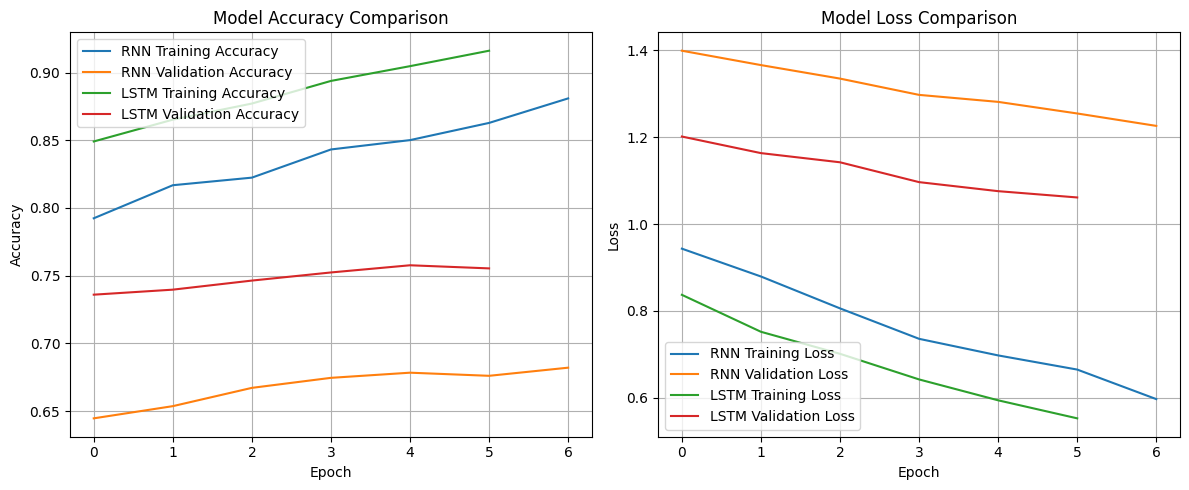

In [9]:
import matplotlib.pyplot as plt


rnn_training_accuracy = [0.7924, 0.8168, 0.8224, 0.8432, 0.8501, 0.8628, 0.8809]  # Add more as needed
rnn_validation_accuracy = [0.6447, 0.6537, 0.6672, 0.6746, 0.6784, 0.6761, 0.6821]
rnn_training_loss = [0.9433, 0.8792, 0.8058, 0.7357, 0.6975, 0.6649, 0.5969]
rnn_validation_loss = [1.3991, 1.3660, 1.3349, 1.2974, 1.2813, 1.2546, 1.2260]

lstm_training_accuracy = [0.8491, 0.8652, 0.8771, 0.8938, 0.9047, 0.9161]
lstm_validation_accuracy = [0.7360, 0.7397, 0.7464, 0.7524, 0.7577, 0.7554]
lstm_training_loss = [0.8370, 0.7519, 0.7012, 0.6422, 0.5941, 0.5526]
lstm_validation_loss = [1.2015, 1.1633, 1.1422, 1.0965, 1.0757, 1.0612]

# Plot Accuracy Comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_training_accuracy, label='RNN Training Accuracy')
plt.plot(rnn_validation_accuracy, label='RNN Validation Accuracy')
plt.plot(lstm_training_accuracy, label='LSTM Training Accuracy')
plt.plot(lstm_validation_accuracy, label='LSTM Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(rnn_training_loss, label='RNN Training Loss')
plt.plot(rnn_validation_loss, label='RNN Validation Loss')
plt.plot(lstm_training_loss, label='LSTM Training Loss')
plt.plot(lstm_validation_loss, label='LSTM Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
